In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as ss

csv_path = "./CSV/"

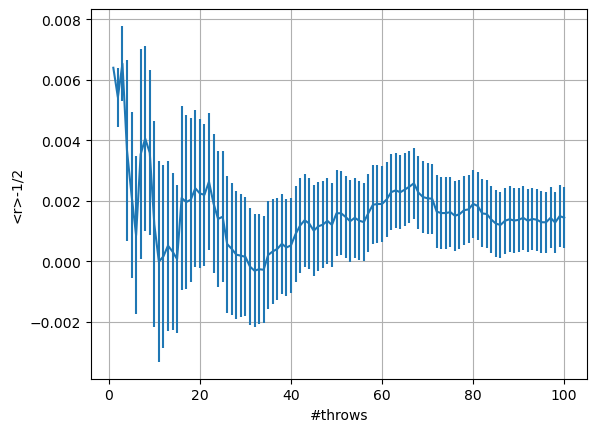

In [3]:
avg_prog, error_prog = np.loadtxt(csv_path + "Ex1_1_1.csv", delimiter=',', usecols=(0, 1), unpack=True)

M = 10000
N = 100

L = M / N

x = np.arange(N) + 1

plt.errorbar(x,avg_prog,yerr=error_prog)
plt.xlabel('#throws')
plt.ylabel('<r>-1/2')
plt.grid(True)
plt.show()

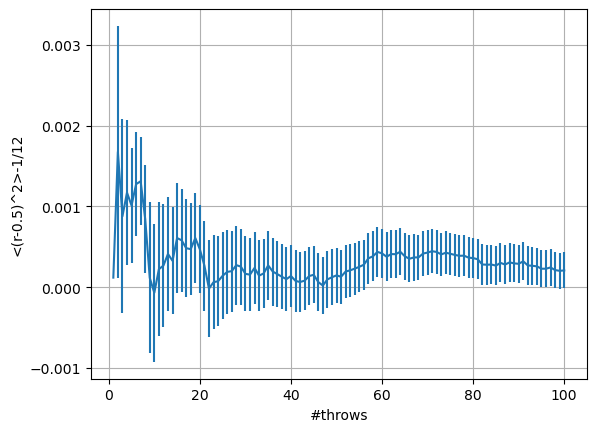

In [4]:
avg_prog, error_prog = np.loadtxt(csv_path + "Ex1_1_2.csv", delimiter=',', usecols=(0, 1), unpack=True)

plt.errorbar(x,avg_prog,yerr=error_prog)
plt.xlabel('#throws')
plt.ylabel('<(r-0.5)^2>-1/12')
plt.grid(True)
plt.show()

In [5]:
def param_chi(x, a):
    
    return a * ss.chi2.pdf(x, df=100)

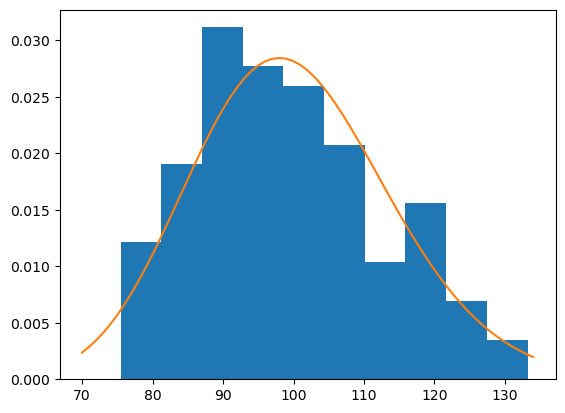

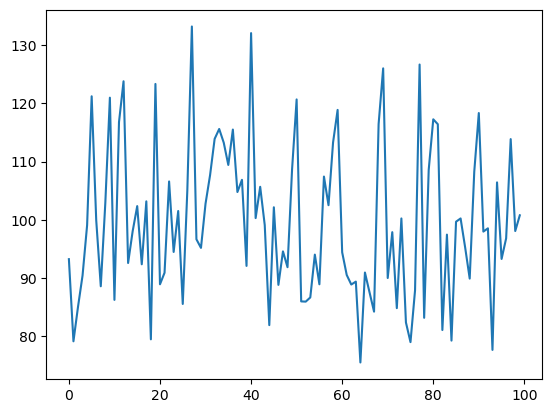

Average Chi2: 99.5756


In [6]:
idx, chi = np.loadtxt(csv_path + "Ex1_1_3.csv", delimiter=',', usecols=(0, 1), unpack=True)

counts, bins = np.histogram(chi)
plt.hist(bins[:-1], bins, weights=counts, density=True)
chi_x=np.arange(70, 135, 1)
plt.plot(chi_x, ss.chi2.pdf(chi_x, df=100))
plt.show()
plt.plot(idx, chi)
plt.show()

print("Average Chi2: " + np.average(chi).astype(str))

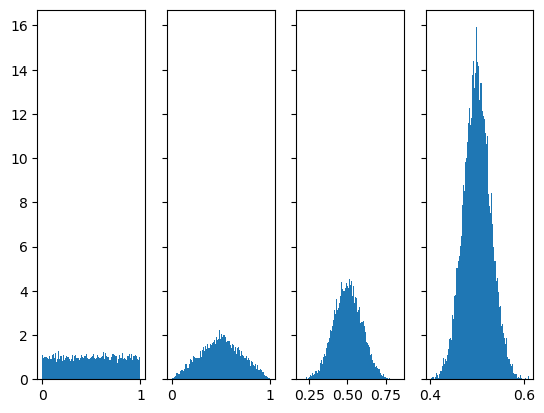

In [7]:
lin_data = np.loadtxt(csv_path + "Ex1_2_lin.csv", delimiter=',')

fig, axs = plt.subplots(1, 4, sharey='row')

for i in range(0, 4):

    counts, bins = np.histogram(lin_data[:,i],100, density=True)
    axs[i].hist(bins[:-1], bins, weights=counts)

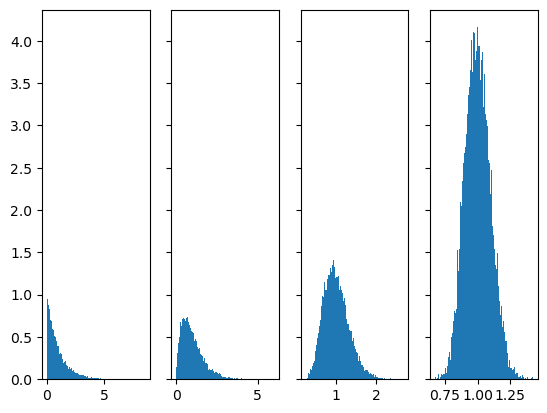

In [8]:
exp_data = np.loadtxt(csv_path + "Ex1_2_exp.csv", delimiter=',')

fig, axs = plt.subplots(1, 4, sharey='row')

for i in range(0, 4):

    counts, bins = np.histogram(exp_data[:,i],100, density=True)
    axs[i].hist(bins[:-1], bins, weights=counts)

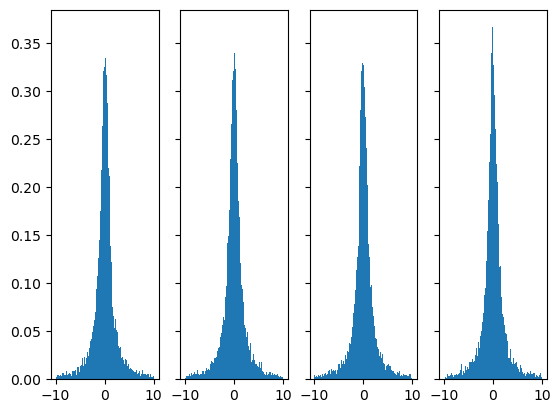

In [9]:
cl_data = np.loadtxt(csv_path + "Ex1_2_cl.csv", delimiter=',')

fig, axs = plt.subplots(1, 4, sharey='row')

for i in range(0, 4):

    counts, bins = np.histogram(cl_data[:,i], 100, [-10, 10], density=True)
    axs[i].hist(bins[:-1], bins, weights=counts)

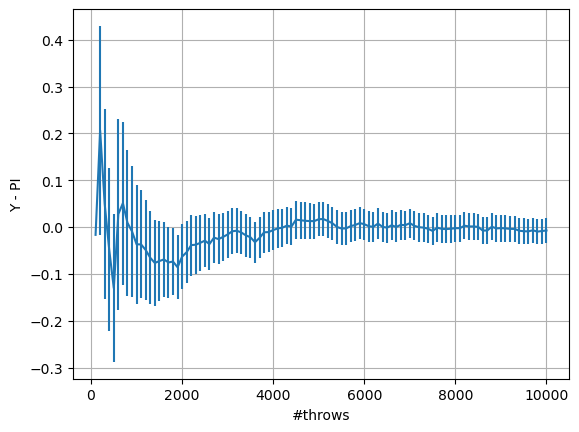

3.1319316999999995


In [19]:
pi_data = np.loadtxt(csv_path + "Ex1_3.csv", delimiter=',')
x = np.arange(1, 101, 1) * 100

plt.errorbar(x,pi_data[:,0] - math.pi,yerr=pi_data[:,1])
plt.xlabel('#throws')
plt.ylabel('Y - PI')
plt.grid(True)
plt.show()

print(np.average(pi_data[:,0]))

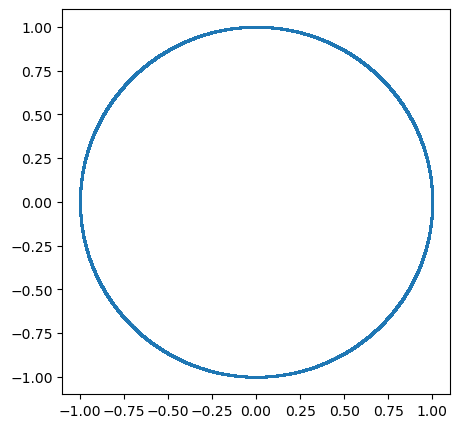

In [18]:
pos_data = np.loadtxt(csv_path + "Ex1_3_pos.csv", delimiter=',')

plt.scatter(pos_data[:,0], pos_data[:,1], s=1)
plt.gcf().set_size_inches(5, 5)
plt.show()